In [1]:
import os
import random
import warnings
from collections import defaultdict
from glob import glob
from pprint import pprint

import cv2
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import (GRU, LSTM, AveragePooling2D, Conv2D,
                                     Dense, Flatten, Input, MaxPooling2D,
                                     Permute, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

In [2]:
TEST_IMAGES_PATH = '../data/processed/test/'
TRAIN_CSV_PATH = '../data/raw/train_data/corrected_train_data.csv'
TRAIN_IMAGES_PATH = '../data/processed/train/'
RANDOM_STATE = 42

In [3]:
PUBLIC_host = 'http://13.234.225.243'
SUBMISSION_URL = PUBLIC_host + ':8080/submit'
LEADERBOARD_URL = PUBLIC_host + ':8080/leaderboard'
DATA_URL = PUBLIC_host + ':9600'

In [4]:
date_range = (0, 8)
image_inp_shape = (100, 450, 1)
tag = "deepak_starter_notebook_corrected_data_label"

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"


seed_everything(RANDOM_STATE)

In [6]:
train_df = pd.read_csv(TRAIN_CSV_PATH, dtype=str)

In [7]:
def model(inp_shape=(100, 450, 1), num_outs=8):
    inp = Input(shape=inp_shape)

    c = Conv2D(8, (3, 3), activation="relu")(inp)
    # c = MaxPooling2D((2,3))(c)
    c = AveragePooling2D((2, 3))(c)

    c = Conv2D(1, (3, 3), activation="relu")(c)
    # c = MaxPooling2D((2,3))(c)
    c = AveragePooling2D((2, 3))(c)

    r = Reshape((int(c.shape[1]), int(c.shape[2])))(c)
    p = Permute((2, 1))(r)

    shared_softmax = Dense(10, activation="softmax")

    outs = []
    for xx in range(num_outs):
        l = LSTM(20, return_sequences=True)(p)
        f = Flatten()(l)
        s = shared_softmax(f)
        outs.append(s)
    if num_outs == 1:
        outs = outs[0]
    model = Model(inputs=inp, outputs=outs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [8]:
def generator(
    batch_size=32,
    image_inp_shape=(450, 100),
    rand_flag=True,
    mode="train",
    train_ratio=0.8,
    date_range=(0, 7),
):
    images_files = glob(TRAIN_IMAGES_PATH + "/*.png")
    train_size = int(len(images_files) * train_ratio)
    images_files = (
        images_files[:train_size] if mode == "train" else images_files[train_size:]
    )
    iter_count = 0
    while True:
        try:
            if rand_flag:
                x_batch = random.sample(images_files, batch_size)
            else:
                x_batch = images_files[
                    iter_count * batch_size : iter_count * batch_size + batch_size
                ]
            iter_count += 1
            y_batch = list(
                map(
                    lambda x: train_df.loc[
                        train_df["tag"] == x.split("/")[-1].split(".")[0]
                    ]["label"].item(),
                    x_batch,
                )
            )
            x_batch = np.array(
                list(
                    map(
                        lambda x: np.expand_dims(
                            cv2.resize(cv2.imread(x, 0), (image_inp_shape)), -1
                        ),
                        x_batch,
                    )
                )
            )
            y_batch = np.eye(10)[
                list(
                    map(
                        lambda x: list(
                            map(
                                lambda xx: int(xx),
                                list(x)[date_range[0] : date_range[1]],
                            )
                        ),
                        y_batch,
                    )
                )
            ]
            y_batch = list(np.swapaxes(y_batch, 0, 1))

            if date_range[1] - date_range[0] == 1:
                y_batch = y_batch[0]

            yield (x_batch, y_batch)
        except Exception as e:
            print(e)
            continue

In [9]:
m = model(inp_shape=image_inp_shape, num_outs=date_range[1] - date_range[0])

In [10]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 450, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 448, 8)   80          input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 49, 149, 8)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 147, 1)   73          average_pooling2d[0][0]          
______________________________________________________________________________________________

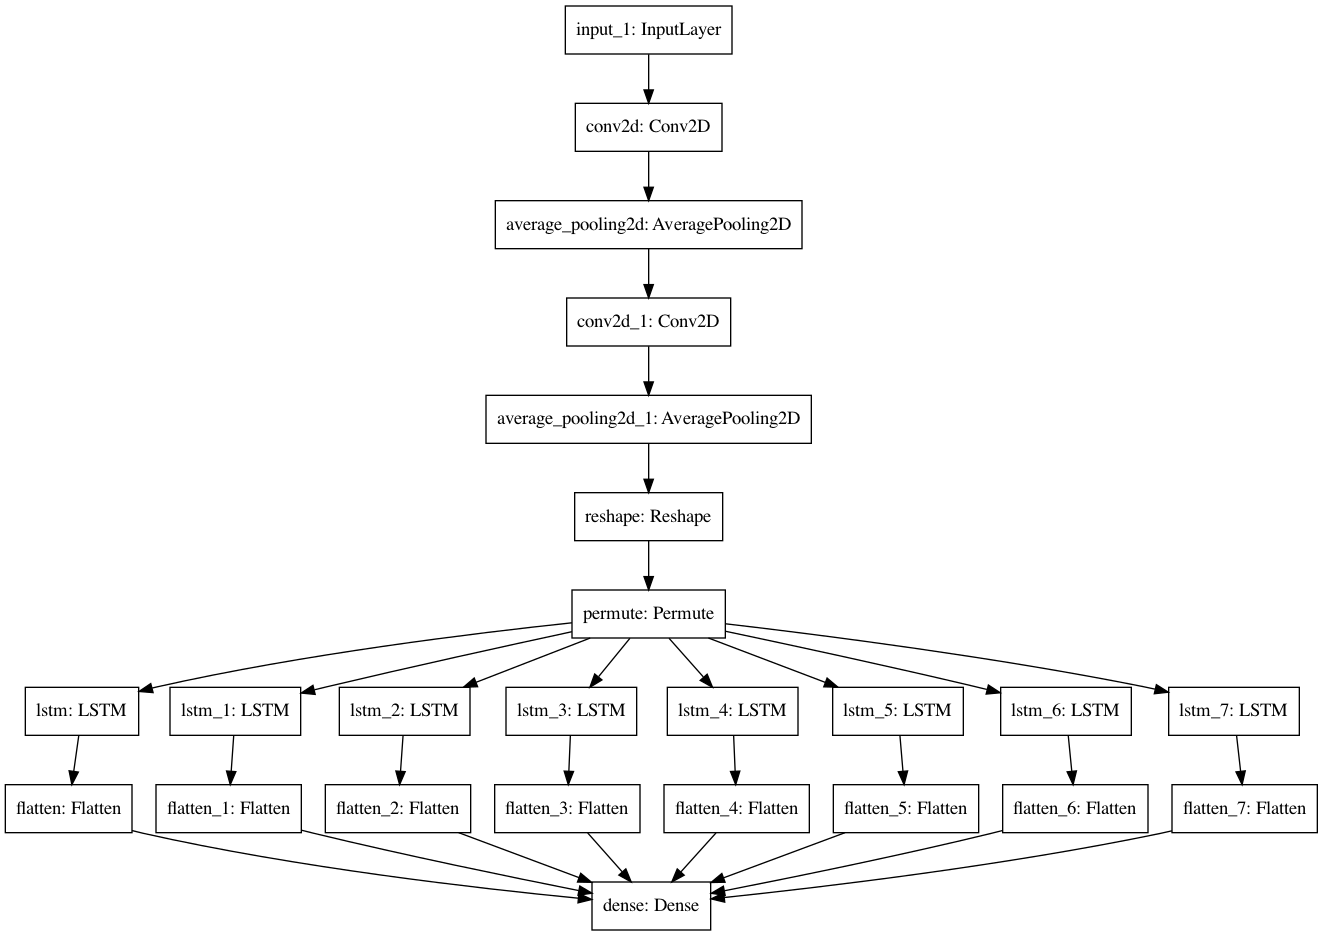

In [11]:
plot_model(m)

In [12]:
model_file_path = f"../models/{tag}_{date_range[0]}-{date_range[1]}.h5"

# callbacks
cbk = ModelCheckpoint(
    model_file_path, monitor="val_loss", save_weights_only=False, save_best_only=True
)
log = CSVLogger(f"../logs/{tag}.log")

# training
m.fit(
    generator(image_inp_shape=(450, 100), date_range=date_range),
    epochs=3,
    steps_per_epoch=300,
    validation_data=generator(
        image_inp_shape=(450, 100), rand_flag=True, mode="val", date_range=date_range
    ),
    validation_steps=100,
    callbacks=[cbk, log],
)

Epoch 1/3
300/300 [==============================] - 174s 580ms/step - loss: 12.6127 - dense_loss: 2.3392 - dense_1_loss: 2.3370 - dense_2_loss: 2.3359 - dense_3_loss: 2.3312 - dense_4_loss: 1.6421 - dense_5_loss: 0.7905 - dense_6_loss: 0.8138 - dense_7_loss: 0.0229 - dense_accuracy: 0.1112 - dense_1_accuracy: 0.1136 - dense_2_accuracy: 0.1179 - dense_3_accuracy: 0.1126 - dense_4_accuracy: 0.2355 - dense_5_accuracy: 0.5352 - dense_6_accuracy: 0.5163 - dense_7_accuracy: 0.9960 - val_loss: 12.1927 - val_dense_loss: 2.3140 - val_dense_1_loss: 2.3210 - val_dense_2_loss: 2.3171 - val_dense_3_loss: 2.2985 - val_dense_4_loss: 1.5856 - val_dense_5_loss: 0.6614 - val_dense_6_loss: 0.6944 - val_dense_7_loss: 7.4691e-04 - val_dense_accuracy: 0.1141 - val_dense_1_accuracy: 0.1219 - val_dense_2_accuracy: 0.1525 - val_dense_3_accuracy: 0.1247 - val_dense_4_accuracy: 0.2709 - val_dense_5_accuracy: 0.6488 - val_dense_6_accuracy: 0.5813 - val_dense_7_accuracy: 1.0000
Epoch 2/3
300/300 [================

In [13]:
# m = load_model(model_file_path)
images_files = glob(TEST_IMAGES_PATH + "/*.png")

s_dict = defaultdict(list)
for image_file in tqdm(images_files):
    x_test = np.expand_dims(cv2.resize(cv2.imread(image_file, 0), (450, 100)), -1)
    pred = m.predict(np.array([x_test]))
    pred_label = "".join(list(map(lambda x: str(np.argmax(x)), pred)))
    s_dict["tag"].append(image_file.split("/")[-1].split(".")[0])
    s_dict["label"].append(pred_label)

sub_df = pd.DataFrame(s_dict)

100%|██████████| 1000/1000 [01:06<00:00, 15.12it/s]


In [20]:
print(sub_df.sample(n=10))

     tag     label
93   969  07213781
692   19  15116781
100  996  25715781
562  718  57244871
729  779  07245881
924  434  31806871
393  660  07813871
685  939  67716781
738  547  07363781
264  511  01514871


In [15]:
sub_df.to_csv(f"../submissions/{tag}.csv", index=False)

In [16]:
sub_json = sub_df.to_json()
data = {
    "username": "deepak",
    "password": "xxxx",
    "submission": sub_json,
    "tag": tag,
}
# r = requests.post(SUBMISSION_URL, json=data)

In [17]:
# r.text

In [18]:
rl = requests.post(LEADERBOARD_URL, json={})
pprint(rl.json())

{'leaderboard': [{'score': 0.0,
                  'submitted_at': '2020-10-24-06-36-1603521407',
                  'tag': 'test2',
                  'username': 'deepak'}],
 'success': True}


**Comparing different versions**

In [21]:
!ls ../logs

deepak_starter_notebook.log
deepak_starter_notebook_corrected_data_label.log
deepak_starter_notebook_corrected_label.log


In [22]:
v1 = pd.read_csv("../logs/deepak_starter_notebook.log")
v2 = pd.read_csv("../logs/deepak_starter_notebook_corrected_label.log")
v3 = pd.read_csv("../logs/deepak_starter_notebook_corrected_data_label.log")

In [41]:
loss_cols, acc_cols, val_loss, val_acc = [], [], [], []

In [42]:
for col in v1.columns:
    if "accuracy" in col and "val" in col:
        val_acc.append(col)
    elif "loss" in col and "val" in col:
        val_loss.append(col)
    elif "accuracy" in col:
        acc_cols.append(col)
    else:
        loss_cols.append(col)

In [43]:
v1.equals(v2)

True

In [44]:
v2[acc_cols]

,dense_1_accuracy,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,dense_5_accuracy,dense_6_accuracy,dense_7_accuracy,dense_accuracy
0,0.105938,0.108021,0.110000,0.220729,0.521979,0.501354,0.995,0.096042
1,0.105625,0.118542,0.109063,0.233021,0.565938,0.611250,1.000,0.100729
2,0.100729,0.127917,0.117812,0.256667,0.614479,0.646042,1.000,0.103646


In [45]:
v3[acc_cols]

,dense_1_accuracy,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,dense_5_accuracy,dense_6_accuracy,dense_7_accuracy,dense_accuracy
0,0.113646,0.117917,0.112604,0.235521,0.535208,0.516250,0.996042,0.111250
1,0.135625,0.150729,0.129896,0.311771,0.698229,0.739583,1.000000,0.137917
2,0.177292,0.184896,0.163646,0.417292,0.771979,0.803854,1.000000,0.183854


*Mean Accuracy Improvement per Layer*

In [62]:
inter = v3[acc_cols]-v2[acc_cols]
inter.mean()

dense_1_accuracy    0.038090
dense_2_accuracy    0.033021
dense_3_accuracy    0.023090
dense_4_accuracy    0.084722
dense_5_accuracy    0.101007
dense_6_accuracy    0.100347
dense_7_accuracy    0.000347
dense_accuracy      0.044201
dtype: float64

In [65]:
print(f"Total Improvement: {inter.mean().mean():.4}")

Total Improvement: 0.0531


**v3 provides better training accuracy for each layer prediction per epoch**

In [46]:
v2[val_acc]

,val_dense_1_accuracy,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,val_dense_5_accuracy,val_dense_6_accuracy,val_dense_7_accuracy,val_dense_accuracy
0,0.120000,0.107813,0.102187,0.217187,0.544062,0.500625,1.0,0.101562
1,0.101250,0.116250,0.105625,0.203125,0.592188,0.647500,1.0,0.105000
2,0.101875,0.119062,0.107188,0.255313,0.643125,0.652500,1.0,0.110937


In [47]:
v3[val_acc]

,val_dense_1_accuracy,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,val_dense_5_accuracy,val_dense_6_accuracy,val_dense_7_accuracy,val_dense_accuracy
0,0.121875,0.152500,0.124688,0.270938,0.648750,0.581250,1.0,0.114063
1,0.145625,0.145313,0.140938,0.322812,0.732188,0.775312,1.0,0.148438
2,0.162500,0.176875,0.169687,0.433750,0.817187,0.834063,1.0,0.186562


*Mean Accuracy Improvement per Layer*

In [66]:
inter = v3[val_acc]-v2[val_acc]
inter.mean()

val_dense_1_accuracy    0.035625
val_dense_2_accuracy    0.043854
val_dense_3_accuracy    0.040104
val_dense_4_accuracy    0.117292
val_dense_5_accuracy    0.139583
val_dense_6_accuracy    0.130000
val_dense_7_accuracy    0.000000
val_dense_accuracy      0.043854
dtype: float64

In [67]:
print(f"Total Improvement: {inter.mean().mean():.4}")

Total Improvement: 0.06879


**v3 provides better validation accuracy for each layer prediction per epoch**

In [73]:
v2[loss_cols]

,epoch,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_loss,loss
0,0,2.341075,2.337235,2.332877,1.643312,0.763215,0.837165,0.022902,2.331624,12.609408
1,1,2.333269,2.309236,2.315906,1.613552,0.682692,0.660943,0.000425,2.317188,12.233210
2,2,2.335443,2.292044,2.304415,1.592408,0.659208,0.629172,0.000316,2.324978,12.137985


In [74]:
v3[loss_cols]

,epoch,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_loss,loss
0,0,2.336973,2.335892,2.331184,1.642135,0.790532,0.813815,0.022908,2.339236,12.612673
1,1,2.293458,2.276264,2.286196,1.551763,0.609693,0.552020,0.000694,2.287953,11.858041
2,2,2.241354,2.222708,2.247694,1.431534,0.514477,0.455145,0.000509,2.221784,11.335208


*Mean Loss Decrease per Layer*

In [75]:
inter = v3[loss_cols]-v2[loss_cols]
inter.mean()

epoch           0.000000
dense_1_loss   -0.046000
dense_2_loss   -0.034550
dense_3_loss   -0.029375
dense_4_loss   -0.074613
dense_5_loss   -0.063471
dense_6_loss   -0.102100
dense_7_loss    0.000156
dense_loss     -0.041606
loss           -0.391561
dtype: float64

In [76]:
print(f"Total Loss Decrease: {inter.mean().mean():.4}")

Total Loss Decrease: -0.07831


In [68]:
v2[val_loss]

,val_dense_1_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_6_loss,val_dense_7_loss,val_dense_loss,val_loss
0,2.316633,2.321096,2.316359,1.645101,0.691157,0.709103,0.000474,2.321125,12.321048
1,2.313920,2.316730,2.308610,1.634061,0.673144,0.642694,0.000384,2.317764,12.207306
2,2.339809,2.318988,2.304337,1.603652,0.641118,0.611043,0.000298,2.305162,12.124406


In [69]:
v3[val_loss]

,val_dense_1_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_6_loss,val_dense_7_loss,val_dense_loss,val_loss
0,2.321014,2.317062,2.298457,1.585629,0.661359,0.694370,0.000747,2.314019,12.192660
1,2.280861,2.276112,2.274319,1.536152,0.569861,0.489693,0.000733,2.272596,11.700329
2,2.250011,2.229839,2.241385,1.401213,0.462808,0.395725,0.000337,2.217527,11.198845


*Mean Loss Decrease per Layer*

In [70]:
inter = v3[val_loss]-v2[val_loss]
inter.mean()

val_dense_1_loss   -0.039492
val_dense_2_loss   -0.044600
val_dense_3_loss   -0.038382
val_dense_4_loss   -0.119940
val_dense_5_loss   -0.103797
val_dense_6_loss   -0.127684
val_dense_7_loss    0.000220
val_dense_loss     -0.046636
val_loss           -0.520308
dtype: float64

In [71]:
print(f"Total Loss Decrease: {inter.mean().mean():.4}")

Total Loss Decrease: -0.1156
